In [2]:
import h5py
import numpy as np
import tonic

h5 = h5py.File('/home/aric/neuromorphic_workshop/lighton.h5', 'r')

events = h5['events_data'][:]
print(events.shape)

def arr_to_struct(arr): 
    #we will cover tonic later. For now just know that it is a format for storing events that is more memory efficient.
    out = np.zeros(len(arr), dtype=[('x', '<i2'), ('y', '<i2'), ('p', '?'), ('t', '<f8')])
    arr[:, 3] = arr[:, 3] * 1e6
    arr[:, 3] = arr[:, 3] - arr[0, 3]
    
    out['x'] = arr[:, 0].astype(np.int16)
    out['y'] = arr[:, 1].astype(np.int16)
    out['p'] = arr[:, 2].astype(bool)
    out['t'] = arr[:, 3].astype(np.float64)
    return out

events = arr_to_struct(events)

(1006608, 4)


# Tonic ftw!
Yesterday we spent the afternoon playing around with how to code different event frames and how to slice event streams. As you saw that it could tedious quite quickly. Tonic is an open source tool that provides a lot of this functionality readily available. We begin by replicating what we did yesterday. Even better, we produce animations of what we did yesterday.

we begin by slicing the event stream ote that tonic provides different ways of slicing. We first replicate the slicing we did yesterday as slicing 30ms windows.

654


Text(0, 0.5, 'Number of events')

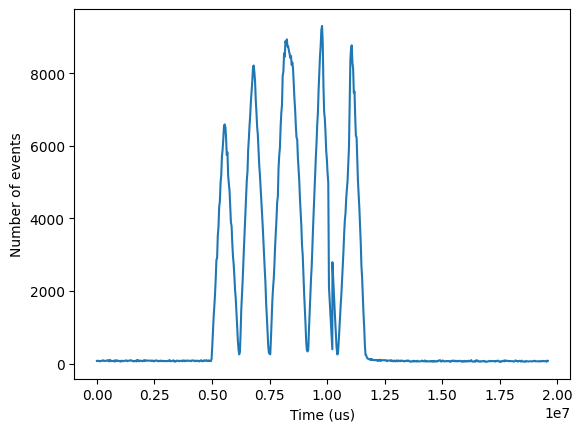

In [3]:
import matplotlib.pyplot as plt
window_slicer = tonic.slicers.SliceByTime(30e3)
sliced_events, _ = window_slicer.slice(events, 0)

print(len(sliced_events))# just like that we have sliced the events into 30 ms windows!

breaks = [window['t'][0] for window in sliced_events if len(window) > 0]
counts = [len(window) for window in sliced_events if len(window) > 0]

plt.plot(breaks, counts)
plt.xlabel('Time (us)')
plt.ylabel('Number of events')


We can also slice by number of events

1006


Text(0, 0.5, 'Time between first and last event (s)')

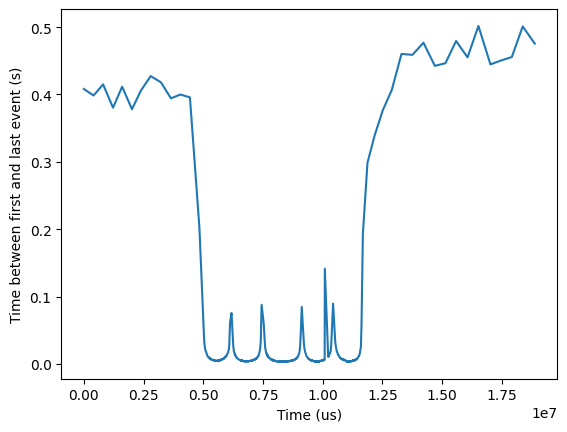

In [135]:
n_events_slicer = tonic.slicers.SliceByEventCount(1000)
sliced_events, _ = n_events_slicer.slice(events, 0)

print(len(sliced_events))

breaks = [window['t'][0] for window in sliced_events if len(window) > 0]
dt = [window[-1]['t'] - window[0]['t'] for window in sliced_events if len(window) > 0]
dt = np.array(dt) * 1e-6

plt.figure()
plt.plot(breaks, dt)
plt.xlabel('Time (us)')
plt.ylabel('Time between first and last event (s)')

We can now convert into time surfaces, histograms, and voxel grids easily

In [ ]:
%matplotlib qt
hist_transform = tonic.transforms.ToFrame((346, 260, 2), 30e3)
histograms = hist_transform(events)

anim = tonic.utils.plot_animation(histograms)
anim.save('histogram.gif', writer='imagemagick', fps=30)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
MovieWriter imagemagick unavailable; using Pillow instead.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB da

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

In [1]:
voxel_transform = tonic.transforms.ToVoxelGrid((346, 260, 2), n_time_bins=100)
voxel_grid = voxel_transform(events)

anim = tonic.utils.plot_animation(voxel_grid)
anim.save('voxel_grid.gif', writer='imagemagick', fps=30)

NameError: name 'tonic' is not defined

In [5]:
%matplotlib qt
timesurf_transform = tonic.transforms.ToTimesurface((346, 260, 2), 30e3, 0.02e6)
timesurfaces = timesurf_transform(events)

anim = tonic.utils.plot_animation(timesurfaces)
anim.save('timesurfaces.gif', writer='imagemagick', fps=30)

MovieWriter imagemagick unavailable; using Pillow instead.


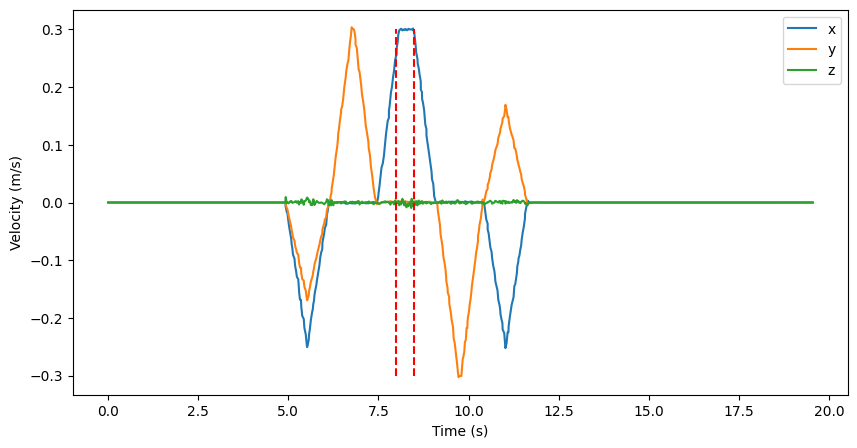

In [11]:
%matplotlib inline
import rosbag 

bag = rosbag.Bag('/home/aric/neuromorphic_workshop/day2/lighton.bag', 'r')

vels = []
ts_vel = []
for topic, msg, t in bag.read_messages(topics=['/tcp_pose', '/tcp/vel']):
    if topic == '/tcp/vel':
        vels.append([msg.linear.x, msg.linear.y, msg.linear.z])
        ts_vel.append(t.to_nsec())

ts_vel = np.array(ts_vel)
ts_vel = (ts_vel - ts_vel[0]) * 1e-9
vels = np.array(vels)

plt.figure(figsize=(10, 5))
plt.plot(ts_vel, vels, label=['x', 'y', 'z'])
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.legend()

#change to your dsataset
plt.vlines([ 8.0, 8.5], -0.3, 0.3, color='r', linestyle='--')

bag.close()


Text(0.5, 0.92, 'Events during motion')

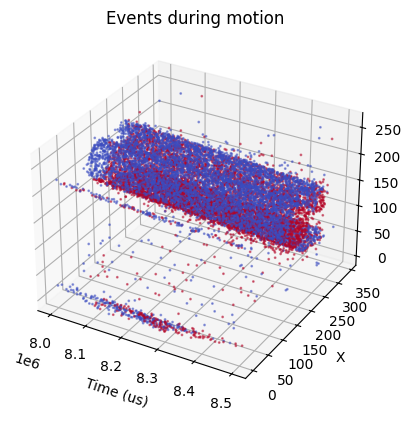

In [12]:
window = np.searchsorted(events['t'], np.array([8.0, 8.5]) * 1e6)
sle = events[window[0]:window[1]][::10]

plt.figure()
ax = plt.subplot(111, projection='3d')
ax.scatter(sle['t'], sle['x'], sle['y'], c=sle['p'], cmap='coolwarm', s=1, alpha=0.5)
plt.xlabel('Time (us)')
plt.ylabel('X')
ax.set_zlabel('Y')
plt.title('Events during motion')


# Contrast maximization and optical flow

The function will take a group of events `evs` and an the optical flow estimate (in px / s) and applies the warp to it. Also implement another function that computes the contrast of motion compensation. Use the histogram with polarities for estimating the contrast. Visualize some warped image and write a function to optimize for contrast to find the optical flow.

In [ ]:
def warp_events(evs, uv):
    #your code here
    warped_events = np.copy(evs)
    return warped_events

In [13]:
def compute_contrast(warped_events):
    #your code here
    contrast = 0
    return contrast

warped_events = warp_events(events, vels)

NameError: name 'warp_events' is not defined